# Reproducing Bolukbasi et al. (2016)

This reproduces a subset of the results from Bolukbasi et al.'s 2016 paper *Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings*. [[source]](https://arxiv.org/pdf/1607.06520.pdf)

The authors show that gender bias is captured by a subspace in the word embedding and that gender-neutral words are linearly separable from words that are gendered by definition (gender-specific words). The authors also provide a methodology for modifying word embeddings to remove gender stereotypes without losing desired associations, which they refer to as debiasing.

## Step 0: Setup

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4]
import numpy as np

from gensim.models import KeyedVectors
from sklearn.svm import LinearSVC

import helpers

###  Load and pre-process word vectors

The paper uses the popular publicly-available 300-dimensional word2vec embedding trained on a corpus of Google News texts consisting of 3 million English words and terms. [[source]](https://code.google.com/archive/p/word2vec/)

Bolukbasi et al. normalize the vector representations of the 50,000 most frequent words and discard all words that consist of at least 20 characters or include upper-case letters, digits, or punctuation were discarded. They keep a total of 26,377 words after filtering. On occasion they use the full set of word embeddings.

In [2]:
# load the roughly most frequent 50,000 words and normalize
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True, limit=50000)
model.init_sims(replace=True)
assert(np.linalg.norm(model['she']) == 1.0)

# find short words without upper-case letters, digits, or punctuations
clean_words = helpers.filter_model(model)
len(clean_words)

26379

### Sanity check for gender-specific words

Bolukbasi et al. identify 218 gender-specific words whose definitions include female, male, woman, man, girl, boy, sister, brother, daughter, son, grandmother, grandfather, wife, or husband. We ensure that all of their gender-specific words are in the filtered set of word embeddings.

In [3]:
with open('data/gender_specific_words.txt', "r") as file_object:
    gender_words = file_object.read()[:-1]
gender_words = np.asarray(gender_words.split(', '))

assert(np.sum(np.isin(gender_words, clean_words, invert=True)) == 0)
gender_words.shape

(218,)

### Selected word vector analogies

Bolukbasi et al. found that many word vector analogies show gender bias and exhibit stereotypes. The following shows a few select word vector analogies. The comments are Bolukbasi et al.'s solutions to the analogies as mentioned in the paper.

In [4]:
# we need the full model for this step
full_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
full_model.init_sims(replace=True)

analogies = [
    ['man', 'computer_programmer', 'woman'], # homemaker
    ['man', 'king', 'woman'], # queen
    ['father', 'doctor', 'mother'], # nurse
    ['john', 'computer_programmer', 'mary'], # homemaker - different!
    ['he', 'coward', 'she'], # whore - different!
    ['she', 'grandmother', 'he'], # grandfather
]

for a in analogies:
    result = full_model.most_similar(positive=[a[2], a[1]], negative=[a[0]], topn=1)[0][0]
    print('{} : {} :: {} : {}'.format(a[0], a[1], a[2], result))

man : computer_programmer :: woman : homemaker
man : king :: woman : queen
father : doctor :: mother : nurse
john : computer_programmer :: mary : graphic_designer
he : coward :: she : slut
she : grandmother :: he : grandfather


### Generating analogies

We can also generate analogies in the form of he : she :: x : y with Bolukbasi et al.'s method (described in Section 4). Since we only consider the most frequent 2000 words due to computational cost, we fail to find the more niche, biased analogies that Bolukbasi et al. mention in their paper. We show the ten highest-scoring analogies along with their score.

In [5]:
analogies = helpers.generate_analogies('she', 'he', model, candidates=clean_words, num=2000)
len(analogies)

3517

In [6]:
analogies[:10]

[('she : he :: her : his', 0.9077807068824768),
 ('she : he :: woman : man', 0.7530544400215149),
 ('she : he :: daughter : son', 0.6747985482215881),
 ('she : he :: girl : boy', 0.6581321954727173),
 ('she : he :: mother : father', 0.6074056625366211),
 ('she : he :: spokeswoman : spokesman', 0.5979806184768677),
 ('she : he :: sister : brother', 0.5973289012908936),
 ('she : he :: girls : boys', 0.595537543296814),
 ('she : he :: daughter : father', 0.5538747310638428),
 ('she : he :: daughter : brother', 0.5529952645301819)]

## Step 1: Identify the gender subspace

Bolukbasi et al. use the centered difference vectors of ten pairs of gender words (defining sets) to identify the gender subspace. Applying PCA to the difference vectors reveals that the direction represented by the first eigenvector captures the majority of variance in these vectors.

### Reproduce Fig. 6

We show the explained variance for the first ten eigenvectors after applying PCA to (1) Bolukbasi et al.'s ten defining pairs for gender and (2) ten randomly sampled pairs averaged over 100 tries to reproduce Figure 6 in their paper. Bolukbasi et al. argue that the decrase in explained variance is much more gradual for (2), suggesting that the large drop in explained variance between the first and second eigenvector for (1) is significant.



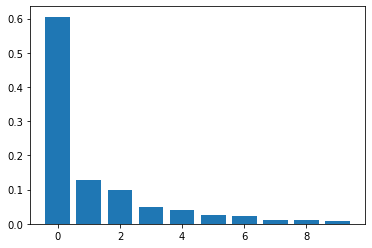

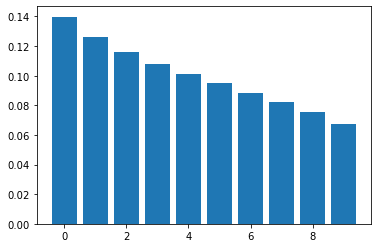

In [7]:
gender_pairs = [
    ('she', 'he'),
    ('her', 'his'),
    ('woman', 'man'),
    ('Mary', 'John'),
    ('herself', 'himself'),
    ('daughter', 'son'),
    ('mother', 'father'),
    ('gal', 'guy'),
    ('girl', 'boy'),
    ('female', 'male')
]

helpers.figure_6(model, k=10, sets=gender_pairs)
helpers.figure_6(model)

### Find the gender subspace

We can now find the gender subspace by applying PCA to the centered difference vectors as described in Section 6, Step 1. Looking at the cosine similarity of each defining pair to the subspace, we can see that some pairs such as ('herself', 'himself') are closer to the final subspace than others, e.g. ('female', 'male').

In [8]:
B = helpers.identify_subspace(gender_pairs, model, k=1, compare=True)[0]

('she', 'he'): similarity = 0.945
('her', 'his'): similarity = 0.914
('woman', 'man'): similarity = 0.821
('Mary', 'John'): similarity = 0.567
('herself', 'himself'): similarity = 0.949
('daughter', 'son'): similarity = 0.749
('mother', 'father'): similarity = 0.692
('gal', 'guy'): similarity = 0.71
('girl', 'boy'): similarity = 0.743
('female', 'male'): similarity = 0.352


## Step 1.5: Learn a classifier for gender-specific/neutral words

Following Section 7 of Bolukbasi et al., we train a linear classifier to identify gender-specific and gender-neutral words. Our training data is the set of 26,379 filtered words, and we predict for the full set of 3 million word embeddings.

In [9]:
clf = LinearSVC(C=1.0, tol=0.0001)
clf.fit(model[clean_words], np.isin(clean_words, gender_words))

vocab = np.array(list(full_model.vocab.keys()))
vectors = full_model[vocab]
predictions = clf.predict(vectors)
print('Number of embeddings: {}'.format(len(predictions)))
print('Number of gender words: {}'.format(np.sum(predictions)))

Number of embeddings: 3000000
Number of gender words: 6366


Bolukbasi et al. identify a total of 6,449 gender-specific words. Some examples are below:

In [10]:
# most common gender words
vocab[predictions][:30]

array(['He', 'her', 'she', 'She', 'man', 'women', 'men', 'woman', 'wife',
       'son', 'mother', 'father', 'daughter', 'husband', 'girls', 'girl',
       'Her', 'boy', 'boys', 'brother', 'sister', 'Women', 'male',
       'herself', 'brothers', 'dad', 'actress', 'mom', 'sons',
       'girlfriend'], dtype='<U98')

In [11]:
# randomly sampled gender words
np.random.choice(vocab[predictions], 20)

array(['Cindy_Iannarelli', 'Prince_Tamino', 'Alfred_Ginglen',
       'idol_Marilyn_Monroe', 'Tima', 'Parvathamma', 'Sylvestor',
       'Jerusalem_Shaare_Zedek', 'Huerkamp', 'Buyuk', 'Mahalko',
       'Walburga', 'outfielder_Bobby_Higginson', 'nephews', 'paramour',
       'Rani_Padmini', 'Arjun_Punj', 'Spanik', 'Emraan', 'Nijinsky_II'],
      dtype='<U98')

### Reproduce Fig. 7

In Figure 7, Bolukbasi et al. project selected words onto the vector difference between 'he' and 'she' (x-axis). The x-axis represents the decision boundary between gender-specific (below) and gender-neutral words (above). The absolute distance to the x-axis represents the distance to the decision boundary.

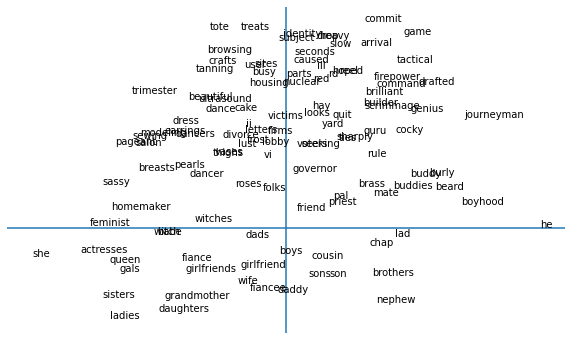

In [12]:
with open('data/figure_7_words.txt', "r") as file_object:
    figure_7_words = np.array(file_object.read()[:-1].split(' '))

plt.rcParams['figure.figsize'] = [10, 6]
helpers.figure_7(figure_7_words, clf, model)

## Step 2a: Hard debiasing

Hard debiasing works by ***neutralizing*** gender-neutral words and ***equalizing*** gender-specific words with otherwise equivalent meanings. Soft debiasing is omitted for this work.

Neutralized words are reembedded such that their vectors are orthogonal to the gender subspace. Equalized words are reembedded such that otherwise equivalent words such as 'father' and 'mother' only differ in the gender subspace, with all other dimensions being set to their average.

### Examples

In [13]:
# gender-neutral words exhibiting gender stereotypes
stereotypes = [
    ('midwife', 'doctor'),
    ('sewing', 'carpentry'),
    ('nurse', 'surgeon'),
    ('softball', 'baseball')
]

# gender-specific words
appropriate = [
    ('her', 'his'),
    ('she', 'he'),
    ('mother', 'father'),
    ('spokeswoman', 'spokesman')
]

B = helpers.identify_subspace(gender_pairs, model, k=1)[0]

In [14]:
_model = helpers.debias(stereotypes, B, model, equal=False, compare=True)

Cosine Similarity with subspace before and after debiasing:
('midwife', 'doctor'): before=0.3, after=0.0
('sewing', 'carpentry'): before=0.39, after=0.0
('nurse', 'surgeon'): before=0.37, after=0.0
('softball', 'baseball'): before=0.44, after=0.0


In [15]:
_model = helpers.debias(appropriate, B, model, equal=True, compare=True)

Cosine Similarity with subspace before and after debiasing:
('her', 'his'): before=0.91, after=0.99
('she', 'he'): before=0.95, after=0.99
('mother', 'father'): before=0.69, after=0.99
('spokeswoman', 'spokesman'): before=0.68, after=0.99


### Fig. 7 after neutralizing gender-neutral words

We neutralize all words that the classifier considers gender-neutral and plot them. We do not change the words that the classifier considers gender-specific since equalizing them requires manually assembling equality sets. Note that the classifier is imperfect: for example, 'he' is classified as gender-neutral. 

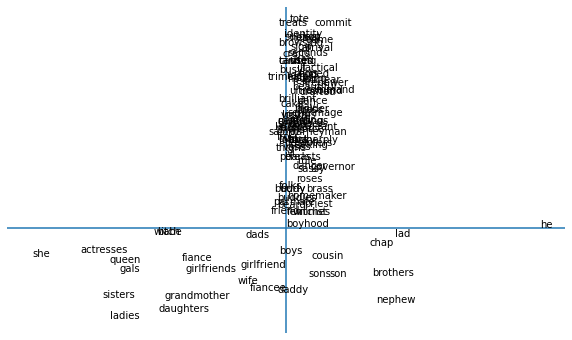

In [16]:
# neutralize all gender-neutral words as determined by classifier
N = [word for word in figure_7_words if word not in vocab[predictions]]
new_model = helpers.neutralize(N, B, model)

# keep gender-specific words as they are
for word in figure_7_words:
    if word not in new_model:
        new_model[word] = model[word]
new_model['he'] = model['he']

helpers.figure_7(figure_7_words, clf, new_model)

We see that all words above the x-axis (i.e. words that the classifier considers to be gender-neutral and that we neutralized) are collapsed roughly onto the y-axis. There is a small discrepancy since the difference between 'she' and 'he' is only an approximation of the gender subspace.